In [2]:
from datetime import datetime
import itertools
import json
import math
import os
import time
import string

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import shapely.wkt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
try:
    from urllib.request import Request, urlopen  # Python 3
except:
    from urllib2 import Request, urlopen  # Python 2
TEST_ORIGIN = '530330001003'
CLASS_LIST = ["urban village", "citywide", "destination park", "supermarket", "library", 
              "hospital", "pharmacy", "post_office", "school", "cafe"]
BASKET_SIZE = 40
# Parameter domains
AA = [0,1,2,3,4] # urban village
BB = [8,9,10,11,12,13] # citywide destination
A = [0,1,2,3] # destination park
B = [0,1,2,3] # supermarket
C = [0,1,2,3] # library
D = [0,1,2,3] # hospital
E = [0,1,2,3] # pharmacy
F = [0,1,2,3] # post office
G = [0,1,2,3] # school
H = [0,1,2,3] # cafe

In [3]:
def proximity_ratio(df_destinations):
    
    # proximity ratio = no. trips under 2 miles / no. trips between 2 and 10 miles; rows with zero denominators are removed
    df_destinations['dist_under_2'] = np.where(df_destinations['distance'] < 2.0, 1, 0)
    df_destinations['dist_2_to_10'] = np.where((df_destinations['distance'] >= 2.0) & (df_destinations['distance'] < 10.0), 1, 0)
    df_blockgroup = df_destinations.groupby(['origin'], as_index=False).agg({'dist_under_2':sum,'dist_2_to_10':sum})
    
    df_blockgroup = df_blockgroup[df_blockgroup['dist_2_to_10'] != 0]   
    df_blockgroup['proximity_ratio_test'] = df_blockgroup['dist_under_2'] / df_blockgroup['dist_2_to_10']
    
    return(df_blockgroup[['origin', 'proximity_ratio_test']])

In [4]:
def vert_hori_ratio(df_destinations, df_blockgroup):
    
    df_destinations['vertical_horizontal_ratio_test'] = pd.DataFrame(np.abs( (df_destinations['dest_lat'] - df_destinations['orig_lat']) / (df_destinations['dest_lng'] - df_destinations['orig_lng']) ))
    df_blockgroup2 = df_destinations.groupby(['origin'], as_index=False)['vertical_horizontal_ratio_test'].mean()
    result_merged = pd.merge(left=df_blockgroup, right=df_blockgroup2, how='inner', left_on='origin', right_on='origin')
    
    return(result_merged)

In [5]:
def average_distance(df_destinations, df_blockgroup):
    
    df_blockgroup2 = df_destinations.groupby(['origin'], as_index=False)['distance'].mean()
    result_merged = pd.merge(left=df_blockgroup, right=df_blockgroup2, how='inner', left_on='origin', right_on='origin')
    result_merged.rename(columns = {'distance': 'average_distance_test'}, inplace=True)
    
    return(result_merged)

In [6]:
"""
Next (Optional in case above three are not good enough) - Moran's I for x and y axes. 
Create weights by pairwise distance matrix for each blockgroup (inverse probability weighting by distance), 
and calculate Moran's I using python package
"""

"\nNext (Optional in case above three are not good enough) - Moran's I for x and y axes. \nCreate weights by pairwise distance matrix for each blockgroup (inverse probability weighting by distance), \nand calculate Moran's I using python package\n"

In [7]:
"""
If we have more time, we can try to compute spatial covariance matrix (might need to normalize the matrix)
and compare a. largest eigenvalues, b. traces, c. determinants.
However, there might be some issues with interpretation (meaning of the measures). 
Also we might need to parallelize the process as it is computationally expensive. 
"""

'\nIf we have more time, we can try to compute spatial covariance matrix (might need to normalize the matrix)\nand compare a. largest eigenvalues, b. traces, c. determinants.\nHowever, there might be some issues with interpretation (meaning of the measures). \nAlso we might need to parallelize the process as it is computationally expensive. \n'

In [8]:
def prepare_psrc(psrc_raw):
    
    # This will compute three features using PSRC data; just need to run it once
    psrc_blockgroup = proximity_ratio(psrc_raw)
    with_vert_hori_ratio = vert_hori_ratio(psrc_raw, psrc_blockgroup)
    with_average_distance = average_distance(psrc_raw, with_vert_hori_ratio)
    
    return (with_average_distance)    

In [28]:
def calculate_features(google_input, basket_combination):
    
    # This calculates three features using google API data; need to run separately for each basket combination
    
    # Filter to match basket parameters based on rank (distance from destination)
    filtered_data = google_input
    for i in range(len(CLASS_LIST)):
        filtered_data = filtered_data[(filtered_data['class'] != CLASS_LIST[i]) | (filtered_data['rank'] <= basket_combination[i])]
   
    # FEATURES: PROXIMITY RATIO, VERTICAL/HORIZONTAL TRAVEL DISTANCES, AVERAGE DISTANCE TO DESTINATION
    
    # Creating google results
    with_proximity_ratio = proximity_ratio(filtered_data.copy())
    with_vert_hori_ratio = vert_hori_ratio(filtered_data.copy(), with_proximity_ratio)
    with_average_distance = average_distance(filtered_data, with_vert_hori_ratio)
    
    return (with_average_distance)

In [10]:
def draw_testplots(psrc_output, google_output):
    
    FEATURE_LIST = ['Proximity Ratio', 'Vertical/Horizontal', 'Average Distance']
    
    for i in range(3):
        plt.scatter(psrc_output.iloc[:,i+1], google_output.iloc[:,i+1])
        plt.xlabel('PSRC: ' + FEATURE_LIST[i], fontsize=15)
        plt.ylabel('Google API:' + FEATURE_LIST[i], fontsize=15)
        plt.xlim(min(psrc_output.iloc[:,i+1].min(), google_output.iloc[:,i+1].min()), 
                 max(psrc_output.iloc[:,i+1].max(), google_output.iloc[:,i+1].max()))
        plt.ylim(min(psrc_output.iloc[:,i+1].min(), google_output.iloc[:,i+1].min()), 
                 max(psrc_output.iloc[:,i+1].max(), google_output.iloc[:,i+1].max()))   
        plt.show()

In [11]:
def calculate_mse(psrc_output, google_input):

    score = []
    combinations = []

    for x in itertools.product(AA,BB,A,B,C,D,E,F,G,H):
        if (sum(x) == BASKET_SIZE):
            combinations.append(x)
            df_google = calculate_features(google_input, list(x))
            googled_psrc = psrc_output.loc[psrc_output['origin'].isin(df_google['origin'])]
            proximity_ratio_mse = mean_squared_error(df_google['proximity_ratio_test'], googled_psrc['proximity_ratio_test'])
            vert_hori_ratio_mse = mean_squared_error(df_google['vertical_horizontal_ratio_test'], googled_psrc['vertical_horizontal_ratio_test'])
            average_distance_mse = mean_squared_error(df_google['average_distance_test'], googled_psrc['average_distance_test'])

            mses = (proximity_ratio_mse, vert_hori_ratio_mse, average_distance_mse)
            #print("combination is :", x)
            score.append(mses)

    print ("Total combinations: " + str(len(combinations)))
    return(score)

In [11]:
"""
At this moment, we might not need evaluate_features function any more..
"""
def evaluate_features(google_input, psrc_input, basket_combination):
    
    """
    This is our main function to compare google API with PSRC data, 
    by comparing three features. 
    
    Input: 
        1. google API data (each row represents one trip)
        2. processed PSRC data (each row represents a blockgroup)
        3. basket combination
        
    The output is a list of three MSEs. 
    """
    
    
    # Filter to match basket parameters based on rank (distance from destination)
    filtered_data = google_input
    for i in range(len(CLASS_LIST)):
        filtered_data = filtered_data[(filtered_data['class'] != CLASS_LIST[i]) | (filtered_data['rank'] <= basket_combination[i])]
    
    # FEATURES: PROXIMITY RATIO, VERTICAL/HORIZONTAL TRAVEL DISTANCES, AVERAGE DISTANCE TO DESTINATION
    
    # Creating google results
    with_proximity_ratio = proximity_ratio(filtered_data.copy())
    with_vert_hori_ratio = vert_hori_ratio(filtered_data.copy(), with_proximity_ratio)
    with_average_distance = average_distance(filtered_data, with_vert_hori_ratio)


    # merge with proximity scores from PSRC
    df_googleAPI = with_average_distance
    #df_psrc = prepare_psrc(psrc_input)
    df_psrc_reduced = psrc_input.loc[psrc_input['origin'].isin(df_googleAPI['origin'])]
    
    # evaluate MSEs and return value
    proximity_ratio_mse = mean_squared_error(df_googleAPI['proximity_ratio_test'], df_psrc_reduced['proximity_ratio_test'])
    vert_hori_ratio_mse = mean_squared_error(df_googleAPI['vertical_horizontal_ratio_test'], df_psrc_reduced['vertical_horizontal_ratio_test'])
    average_distance_mse = mean_squared_error(df_googleAPI['average_distance_test'], df_psrc_reduced['average_distance_test'])

    print("proximity ratio mse: ", proximity_ratio_mse)
    print("vertical horizontal ratio mse: ", vert_hori_ratio_mse)
    print("average distance mse: ", average_distance_mse)
    result = [proximity_ratio_mse, vert_hori_ratio_mse, average_distance_mse]
    # Don't forget to normalize the values in order to compare them!
     
    return (result)   

In [29]:
# Load PSRC data and pre-process; column names should be determined at a group meeting
psrc_rawdat = pd.read_csv("psrc_data_final.csv", dtype={'o_bg': str, 'd_bg': str})
psrc_rawdat['origin'] = '530330' + psrc_rawdat['o_bg']
psrc_rawdat['destination'] = '530330' + psrc_rawdat['d_bg']
psrc_orig_pts = psrc_rawdat['o_bg_lat_long'].apply(shapely.wkt.loads)
psrc_dest_pts = psrc_rawdat['d_bg_lat_long'].apply(shapely.wkt.loads)
psrc_rawdat['orig_lng'] = pd.DataFrame([kk.x for kk in psrc_orig_pts])
psrc_rawdat['orig_lat'] = pd.DataFrame([kk.y for kk in psrc_orig_pts])
psrc_rawdat['dest_lng'] = pd.DataFrame([kk.x for kk in psrc_dest_pts])
psrc_rawdat['dest_lat'] = pd.DataFrame([kk.y for kk in psrc_dest_pts])
psrc_rawdat.drop(columns = ['o_bg', 'o_bg_lat_long', 'd_bg', 'd_bg_lat_long'], inplace=True)
psrc_rawdat.rename(columns = {'trip_path_distance': 'distance', 'trip_weight_revised': 'weight'}, inplace=True)
psrc_rawdat['distance'] = pd.to_numeric(psrc_rawdat['distance'], errors='coerce')

In [30]:
# Load Google API data 
# df_sample = pd.read_csv('Proximity_Ratio.csv', dtype={'bg_origin': str}) 
input_destinations = pd.read_csv('GoogleMatrix_Places_Dist.csv', dtype={'origin': str})
input_destinations.rename(columns = {'lat': 'dest_lat', 'lng': 'dest_lng'}, inplace=True)

In [31]:
# Load blockgroup data with latitude and longitudes; will be merged with Google API
blockgroup_mapping = pd.read_csv('SeattleCensusBlockGroups.csv', dtype={'tract_blkgrp': str})
blockgroup_mapping['tract_blkgrp'] = '530330' + blockgroup_mapping['tract_blkgrp']
orig_pts = blockgroup_mapping.centroid.apply(shapely.wkt.loads)
blockgroup_mapping['orig_lng'] = pd.DataFrame([kk.x for kk in orig_pts])
blockgroup_mapping['orig_lat'] = pd.DataFrame([kk.y for kk in orig_pts])
origin_blockgroups = blockgroup_mapping [['tract_blkgrp', 'orig_lat', 'orig_lng']]

In [32]:
# origin_merged will be an input data for 'evaluate_features' function
origin_merged = pd.merge(left=input_destinations, right=origin_blockgroups, how='left', left_on='origin', right_on='tract_blkgrp')
origin_merged = origin_merged[['origin', 'dest_lat', 'orig_lat','dest_lng', 'orig_lng', 'rank', 'distance', 'class']]

In [33]:
# One-time computation of psrc: generate three features
df_psrc = prepare_psrc(psrc_rawdat)

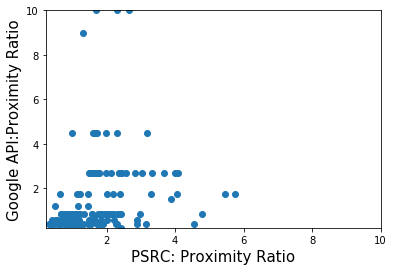

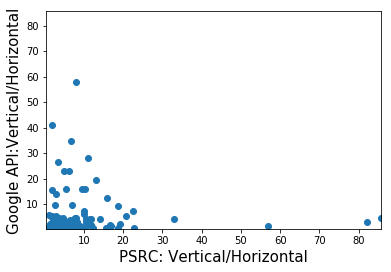

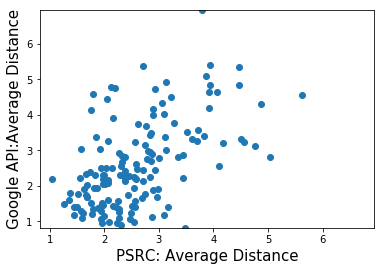

In [34]:
"""
You can play around here!
"""
#testArray = [3, 5, 2, 2, 2, 2, 3, 0, 1, 2]
testArray = [0, 8, 0, 0, 0, 0, 0, 0, 0, 3]
df_google = calculate_features(origin_merged, testArray)
googled_psrc = df_psrc.loc[df_psrc['origin'].isin(df_google['origin'])]
draw_testplots(googled_psrc, df_google)

In [18]:
"""plt.scatter(googled_psrc['proximity_ratio_test'], df_google['proximity_ratio_test'])
plt.xlim(0, 6)
plta.ylim(0, 6)
plt.show()
"""

"plt.scatter(googled_psrc['proximity_ratio_test'], df_google['proximity_ratio_test'])\nplt.xlim(0, 6)\nplta.ylim(0, 6)\nplt.show()\n"

In [35]:
res = calculate_mse(df_psrc, origin_merged)
res

Total combinations: 10


[(0.92831001602169649, 150.51356526780901, 0.56153795207876422),
 (1.1879866302536732, 151.0959998994615, 0.63151922866236943),
 (1.1855658276286829, 150.71955168596983, 0.58960549195715772),
 (0.94437124615629742, 150.60749462433014, 0.56786872892227713),
 (0.99699404429355509, 150.48021396092469, 0.57317598414539195),
 (0.93858305500100447, 150.92485665520638, 0.5536702418884093),
 (0.94261302141470271, 150.30192461837291, 0.56362062306771321),
 (0.95538929074806256, 150.60740663996859, 0.56313945328906678),
 (0.94663720645912974, 150.39023261820358, 0.57243058749317755),
 (0.94258884829904865, 150.15683049075201, 0.55955939248092057)]

In [21]:
origin_merged.head()
df_psrc.head()

,origin,proximity_ratio_test,vertical_horizontal_ratio_test,average_distance_test
0,530330001001,0.666667,3.736674,5.789315
1,530330001002,1.666667,3.323772,3.868794
2,530330001003,4.545455,1.282848,1.798165
3,530330001004,0.000000,0.701157,5.967649
4,530330001005,1.200000,11.951093,2.122622


In [27]:
k = [list(a) for a in zip(*[[1, 2], [3, 4], [5, 6]])]
k

[[1, 3, 5], [2, 4, 6]]

In [6]:
dd = [0, 1]
ee = [1, 2]
list(itertools.product(dd, ee))

[(0, 1), (0, 2), (1, 1), (1, 2)]